In [1]:
import pandas as pd
from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
from skbio import TreeNode
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

In [2]:
table = load_table('../data/cfs/final.withtax.biom')
metadata = pd.read_table('../data/cfs/map.txt', index_col=0)
taxa = pd.read_table('../data/cfs/taxa.txt', index_col=0)

In [3]:
from gneiss.util import match
otu_filter = lambda val, id_, md: val.sum() > 10
id_filter = lambda val, id_, md: id_ in metadata.index
sparse_filter = lambda val, id_, md: (val>0).sum() > 10
table = table.filter(id_filter, axis='sample')
table = table.filter(otu_filter, axis='observation')
table = table.filter(sparse_filter, axis='observation')

table = pd.DataFrame(np.array(table.matrix_data.todense()).T, 
                     index=table.ids(axis='sample'),
                     columns=table.ids(axis='observation'))
table, metadata = match(table, metadata)

In [4]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement
ctable = pd.DataFrame(clr(centralize(table+1)),
                      index=table.index, columns=table.columns)

rfc = PLSRegression(n_components=2)
rfc.fit(X=ctable.values, Y=metadata.Subject=='Patient')

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

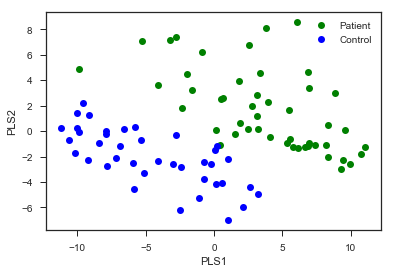

In [5]:
midx = metadata.Subject=='Patient'
lidx = metadata.Subject=='Control'
plt.plot(rfc.x_scores_[midx, 0], rfc.x_scores_[midx, 1], 'og', label='Patient')
plt.plot(rfc.x_scores_[lidx, 0], rfc.x_scores_[lidx, 1], 'ob', label='Control')
plt.xlabel('PLS1')
plt.ylabel('PLS2')
plt.legend()

In [6]:
rfc = PLSRegression(n_components=1)
rfc.fit(X=ctable.values, Y=metadata.Subject=='Patient')

PLSRegression(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

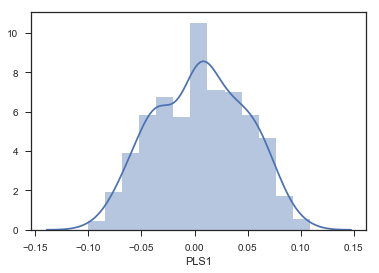

In [7]:
pls_df = pd.DataFrame(rfc.x_weights_, index=ctable.columns, columns=['PLS1'])
sns.distplot(pls_df.PLS1)

In [8]:
from sklearn.mixture import GaussianMixture
gmod = GaussianMixture(n_components=3, 
                       means_init=[[-0.1], [0], [0.1]])
gmod = GaussianMixture(n_components=3)
gmod.fit(X=pls_df.values)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

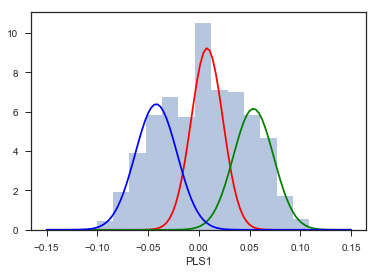

In [9]:
from scipy.stats import norm

m = np.ravel(gmod.means_)
s = np.ravel(np.sqrt(gmod.covariances_)) 
w = np.ravel(gmod.weights_)

x = np.linspace(-0.15, 0.15, 100)
sns.distplot(pls_df.PLS1, norm_hist=True, kde=False)
plt.plot(x, w[0]*norm.pdf(x, m[0], s[0]), '-r')
plt.plot(x, w[1]*norm.pdf(x, m[1], s[1]), '-g')
plt.plot(x, w[2]*norm.pdf(x, m[2], s[2]), '-b')

In [11]:
from src.balances import round_balance
l, r = round_balance(pls_df.values)

In [12]:
denom = pls_df.loc[pls_df.PLS1 < l]
num = pls_df.loc[pls_df.PLS1 > r]

In [13]:
pls_balance = np.log(table.loc[:, num.index] + 1).mean(axis=1) - np.log(table.loc[:, denom.index] + 1).mean(axis=1)

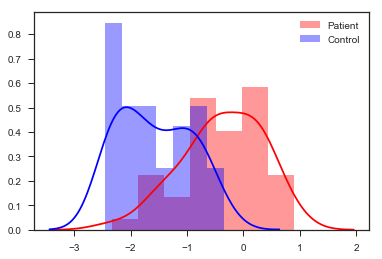

In [14]:
sns.distplot(pls_balance[metadata.Subject=='Patient'], label='Patient', color='r', bins=7)
sns.distplot(pls_balance[metadata.Subject=='Control'], label='Control', color='b', bins=7)
plt.legend()

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


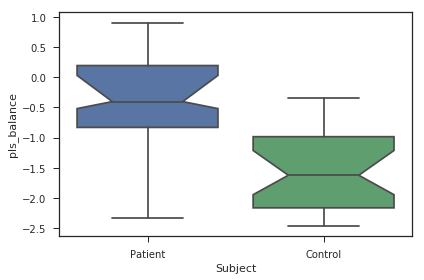

In [15]:
from gneiss.plot import balance_boxplot, balance_barplots
from matplotlib import rc

sns.set_style('white')
sns.set_style('ticks')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

fig, ax = plt.subplots()
metadata['pls_balance'] = pls_balance
sns.boxplot(x='Subject', y='pls_balance', data=metadata, ax=ax, notch=True, bootstrap=1000)
plt.tight_layout()

In [17]:
taxa.loc[num.index].shape

(162, 1)

In [18]:
taxa.loc[denom.index].shape

(176, 1)